## Simulating Ensemble Sorting

### import statements and graphing set up

In [28]:
from matplotlib import pyplot as plt
import random
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy.optimize
from collections import namedtuple
from math import ceil, floor
import json
import copy
import pickle

%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (12, 12 / 4 * 3)

## defining chambers class

In [22]:
class chambers():
    
    def __init__(self, start_chamber, hi_lim, low_lim, size, fraction, bunch_size, rand_bunch='Const'):
        '''
        Initialize the constants as well as the dynamic chambers
        '''
        self.chambers = {"A1":[], "A2": [], "B1":[], "B2":[]}
        self.sorted_chamber = start_chamber  # the chamber that is currently being sorted
        self.states = [True, False]  # the possible objects. In the case just 2 are allowed.
        self.hi_lim = hi_lim  # upper threshold to stop
        self.low_lim = low_lim  # lower threshold to stop
        self.size = size  # total number of objects
        self.fraction = fraction  # initial ratio between populations
        self.bunch_size = bunch_size  # default size of bunch/ensemble
        self.rand_bunch = rand_bunch  # flag for the kind of bunch/ensemble distribution
        
    def populate_chambers(self):
        self.chambers[self.sorted_chamber] = [self.states[0] if random.random() <= self.fraction else
                                              self.states[1] for i in range(self.size)]
        
    def get_bunch_size(self):
        # return the size of the bunch, if rand_bunch flag is set creates it using a gaussian dist. w/ the negative trimmed
        if self.rand_bunch == 'Norm':
            while True:
                size = random.normalvariate(self.bunch_size, self.bunch_size/2)
                if size > 0:
                    size = ceil(size)
                    return size
        elif self.rand_bunch == 'Bead':  # using an extracted bead bunch size distribution
            with open('beaddist.json', 'r') as f:
                vals = json.load(f)
            vs, ps = zip(*vals)
            beaddist = stats.rv_discrete(values=(vs, ps))
            return beaddist.rvs(size=1)[0]
        elif self.rand_bunch == 'Droplets':  # using an extraced droplet bunch size distribution
            with open('droplet-exp-dist.json', 'r') as f:
                vals = json.load(f)
            vs, ps = zip(*vals)
            beaddist = stats.rv_discrete(values=(vs, ps))
            return beaddist.rvs(size=1)[0]
        elif self.rand_bunch == 'Const':
            return self.bunch_size
        elif self.rand_bunch == 'Bi':
            return random.choice((2,10))
        else:
            raise ValueError('Distribution type not acceptible')
    
    def make_bunch(self):
        chamber = self.chambers[self.sorted_chamber]
        size = self.get_bunch_size()
        if size > len(chamber):
            size = len(chamber)
        return [chamber.pop() for i in range(size)]

## create experiment class

In [23]:
class Experiment():
    
    def __init__(self, hi_lim, low_lim, start_chamber, size, fraction, bunch_size, rand_bunch, prec, classify_odds):
        self.data = []
        self.sorted_chamber = start_chamber
        self.runnable = [True, True, True, True]
        self.running = True
        self.chamber_list = ("A1", "A2", "B1", "B2")
        self.chambs = chambers(start_chamber, hi_lim, low_lim, size, fraction, bunch_size, rand_bunch)
        self.chambs.populate_chambers()
        self.prec = prec  # movement precision (getting bunch into intended chamber)
        self.classify_odds = classify_odds  # odds of correct classification
        
    def run(self, max_sorts=1):
        # run through the chambers untill all have met the stopping criteria
        counter = 0
        while self.running:
            for idx, chamber in enumerate(self.chamber_list):
                counter += 1
                Trues, Falses = self.calc_ratio_4save()
                self.data.append((Trues, Falses))
                self.runnable[idx] = True
                self.chambs.sorted_chamber = chamber
                self.sorting()
            if True not in self.runnable or counter >= max_sorts:
                return self.data
        
    def is_runnable(self, chamber):
        # checking the stopping criteria
        if len(self.chambs.chambers[chamber]) == 0:
            return False
        else:
            Trues = sum(self.chambs.chambers[chamber])
            Falses = len(self.chambs.chambers[chamber]) - Trues
            ratio = Trues / (Trues + Falses)
            if ratio >= self.chambs.low_lim or ratio >= self.chambs.hi_lim:
                return False
        return True

    def move_bunch_enrich(self, bunch):
        # move into the relavent chamber for enrichment case
        temp = [state if random.random() < self.classify_odds else not state for state in bunch]
        ratio = temp.count(self.chambs.states[0]) / (temp.count(self.chambs.states[0]) + temp.count(self.chambs.states[1]))
        if self.chambs.sorted_chamber[0] == 'A':
            end = 'B'
        else:
            end = 'A'
        if temp.count(self.chambs.states[0]) >= 1:
            end += '1'
        else:
            end += '2'
        if random.random() > self.prec:
            if end[1] == '1':
                end = end.replace('1', '2')
            elif end[1] == '2':
                end = end.replace('2', '1')
        for particle in bunch:
            self.chambs.chambers[end].append(particle)   
    
    def move_bunch(self, bunch):
        # move into the relavent chamber for standard sorting
        # using temp to add misclassification rate
        temp = [state if random.random() < self.classify_odds else not state for state in bunch]
        ratio = temp.count(self.chambs.states[0]) / (temp.count(self.chambs.states[0]) + temp.count(self.chambs.states[1]))
        if self.chambs.sorted_chamber[0] == 'A':
            end = 'B'
        else:
            end = 'A'
        if ratio > 0.5:
            end += '1'
        elif ratio < 0.5:
            end += '2'
        elif ratio == 0.5:
            end += random.choice(('1', '2'))
        if random.random() > self.prec:
            if end[1] == '1':
                end = end.replace('1', '2')
            elif end[1] == '2':
                end = end.replace('2', '1')
        for particle in bunch:
            self.chambs.chambers[end].append(particle)    

    def calc_ratio_4save(self):
        # ratio_True is the number of True states in 'True' chambers
        # ratio_False is the number of True states in 'False' chambers
        A1Trues = self.chambs.chambers["A1"].count(True)
        A2Trues = self.chambs.chambers["A2"].count(True)
        B1Trues = self.chambs.chambers["B1"].count(True)
        B2Trues = self.chambs.chambers["B2"].count(True)
        A1Size = len(self.chambs.chambers["A1"])
        A2Size = len(self.chambs.chambers["A2"])
        B1Size = len(self.chambs.chambers["B1"])
        B2Size = len(self.chambs.chambers["B2"])
        if A1Size + B1Size == 0:
            ratio_True = None
        else:
            ratio_True = (A1Trues + B1Trues) / (A1Size + B1Size)
        if A2Size + B2Size == 0:
            ratio_False = None
        else:
            ratio_False = (A2Size - A2Trues + B2Size - B2Trues) / (A2Size + B2Size)
        return ratio_True, ratio_False
                

    def sorting(self):
        chamber = self.chambs.chambers[self.chambs.sorted_chamber]
        while len(chamber) != 0:
            random.shuffle(chamber)
            bunch = self.chambs.make_bunch()
#             self.move_bunch_enrich(bunch)  # for enrichment case
            self.move_bunch(bunch)

## making a custom distribution from the real bead data

In [ ]:
with open('beaddist.json', 'r') as f:
    vals = json.load(f)
vs, ps = zip(*vals)
beaddist = stats.rv_discrete(values=(vs, ps))
plt.hist(beaddist.rvs(size=1000));

## simulate function that runs the 'experiments' and collects the data and configuration namedtuple
### need to define configuration parameters before running it

In [24]:
def simulate(runs, conf):
    data = []
    for i in range(runs):
        experiment = Experiment(conf.hi_lim, conf.low_lim, conf.start_chamber, conf.size, conf.fraction,
                                conf.bunch_size, conf.rand_bunch, conf.prec, conf.classify_odds)
        data.append(np.array(experiment.run(max_sorts=conf.max_sortings)))
        # need to use a list of numpy arrays because their lengths are different
    return data

config = namedtuple('config', ['hi_lim', 'low_lim', 'start_chamber', 'size', 'fraction', 'max_sortings',
                              'bunch_size', 'rand_bunch', 'prec', 'classify_odds'])

## plotting and organizing functions

In [25]:
def plot_single(data, experiment_number):
    plt.figure(experiment_number)
    plt.title("Plot of single experiment number {}".format(experiment_number))
    plt.xlabel("Number of sorting cycles")
    plt.ylabel("Ratio of states in the whole system")
    plt.plot(all_data[experiment_number])
    plt.show()
    
    
def plot_mean(ps, fit=False):
    plt.figure('mean')
    average=ps.mean(axis=1)
    plt.plot(average, label="ration of Highs")
    plt.title("Mean experiment")
    plt.xlabel("Number of sorting cycles")
    plt.ylabel("Ratio of the 'high' state in the whole system")
    if fit:
        def func(x, a, b, c):
            return a * np.exp(-b * x) + c
        xdata = np.linspace(0, len(average), len(average))
        popt, pcov = scipy.optimize.curve_fit(func, xdata, average)
        plt.plot(xdata, func(xdata, *popt), label="Fit")
    plt.legend(bbox_to_anchor=(1, 0.3))
    plt.show()        
    if fit:
        print('Fitting parameters are {}, {}, {}'.format(*popt))

    
def plot_median(data, fit=False):
    try:
        lengths = [i.shape[0] for i in data]
        median_ind = np.min(np.where(lengths == np.ceil(np.median(lengths))))
        median = [point[0] for point in data[median_ind]]
        plt.figure(median_ind)
        plt.title("Plot of a Median expeirment")
        plt.xlabel("Number of sorting cycles")
        plt.ylabel("Ratio of states in the whole system")
        plt.plot(median, label='ratio of Highs')
        if fit:
            def func(x, a, b, c):
                return a * np.exp(-b * x) + c
            xdata = np.linspace(0, len(median), len(median))
            popt, pcov = scipy.optimize.curve_fit(func, xdata, median)
            plt.plot(xdata, func(xdata, *popt), label='Fit')
        plt.legend(bbox_to_anchor=(1, 0.3))
        plt.show()
        if fit:
            print('Fitting parameters are {}, {}, {}'.format(*popt))
    except TypeError:
        print("No single median measurement exists")

        
def plot_all(ps):
    ax = ps.plot(legend=None)
    ax.set_title("Plot of all experiments")
    ax.set_xlabel("Number of sortings")
    ax.set_ylabel("Degree of separation")
    plt.show()
    
    
def plot_exp_dist(data):
    lengths = [i.shape[0] for i in data]
    print("Statistics for experiment lengths: Mean: {}, Median: {}, std: {}".format(
            np.mean(lengths), np.median(lengths), np.std(lengths)))
    plt.hist(lengths, bins = range(0,np.max(lengths) + 5, 5))
    plt.title("Histogram of experiment length distribution")
    plt.xlabel("Length of experiment (no. of sortings)")
    plt.ylabel("Frequency")
    plt.show()
    #fit_alpha, fit_loc, fit_beta=stats.gamma.fit(lengths)
    #print(fit_alpha, fit_loc, fit_beta)


def prep_4plot(data):
    list_series = []
    for j in data:
        y = [i[0] for i in j]
        list_series.append(pd.Series(y))
    ps = pd.DataFrame(list_series)
    ps = ps.transpose()
    return ps

## saving and loading data (recommeneded since it can take some time to perform the simulations)

In [26]:
# make sure the pickles directory exists
def savepkl(name, obj):
    with open('pickles\\' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)
        
def loadpkl(name):
    with open('pickles\\' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

## example simple simulation

In [7]:
config1 = config(hi_lim=1, low_lim=0, start_chamber='A1', size=200, fraction=0.5, max_sortings=30,
               bunch_size=3, rand_bunch='Bead', prec=1, classify_odds=1)
simple_all_data = simulate(1, conf=config1)
simple_ps = prep_4plot(simple_all_data)

In [ ]:
savepkl(name='simple_all_data', obj=simple_all_data)

In [8]:
simple_all_data

[array([[0.485, None],
        [0.7931034482758621, 0.7522123893805309],
        [0.7931034482758621, 0.7522123893805309],
        [0.9178082191780822, 0.7637795275590551],
        [0.8631578947368421, 0.8571428571428571],
        [0.9176470588235294, 0.8347826086956521],
        [0.9052631578947369, 0.8952380952380953],
        [0.9555555555555556, 0.9],
        [0.9479166666666666, 0.9423076923076923],
        [0.9888888888888889, 0.9272727272727272],
        [0.9891304347826086, 0.9444444444444444],
        [0.9891304347826086, 0.9444444444444444],
        [0.9895833333333334, 0.9807692307692307],
        [1.0, 0.9809523809523809],
        [1.0, 0.9809523809523809],
        [1.0, 0.9809523809523809],
        [0.9896907216494846, 0.9902912621359223],
        [1.0, 0.9903846153846154],
        [1.0, 0.9903846153846154],
        [1.0, 0.9903846153846154],
        [1.0, 0.9903846153846154],
        [1.0, 0.9903846153846154],
        [1.0, 0.9903846153846154],
        [1.0, 0.99038461538

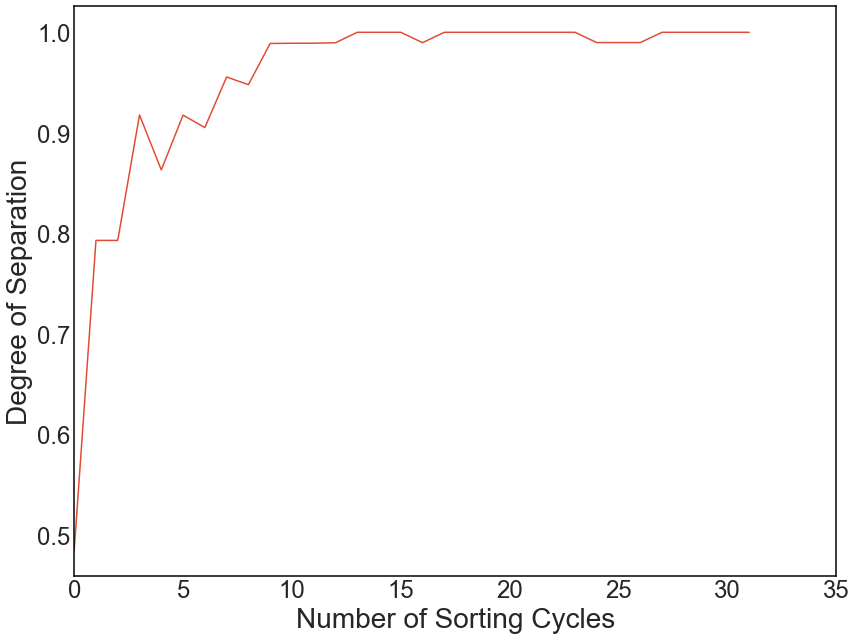

In [18]:
simple_ps.plot()
ax = plt.axes()
ax.grid(False)
ax.spines['top'].set_color('k')
ax.spines['top'].set_linewidth(1.5)
ax.spines['left'].set_color('k')
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_color('k')
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_color('k')
ax.spines['bottom'].set_linewidth(1.5)
plt.legend().remove()
plt.xlim([0, 35])
plt.xlabel("Number of Sorting Cycles", fontsize=28)
plt.ylabel("Degree of Separation", fontsize=28);
plt.yticks(fontsize=24)
plt.xticks(fontsize=24)
plt.tight_layout()

## running over the misclassification rate

In [36]:
data = []
for clas in np.arange(0.5, 1.01, .1):
    print('in fraction', clas)
    config1 = config(hi_lim=1, low_lim=0, start_chamber='A1', size=1500, fraction=0.5, max_sortings=2000,
               bunch_size=3, rand_bunch='Const', prec=1, classify_odds=clas)
    all_data = simulate(5, conf=config1)
    ps = prep_4plot(all_data).mean(axis=1)
    ps.name = str(clas)
    data.append(ps)
classifiers = pd.DataFrame(data).transpose()

in fraction 0.5
in fraction 0.6
in fraction 0.7
in fraction 0.8
in fraction 0.9
in fraction 1.0


In [37]:
savepkl(name='classifiers', obj=classifiers)

In [38]:
classifiers = loadpkl('classifiers')

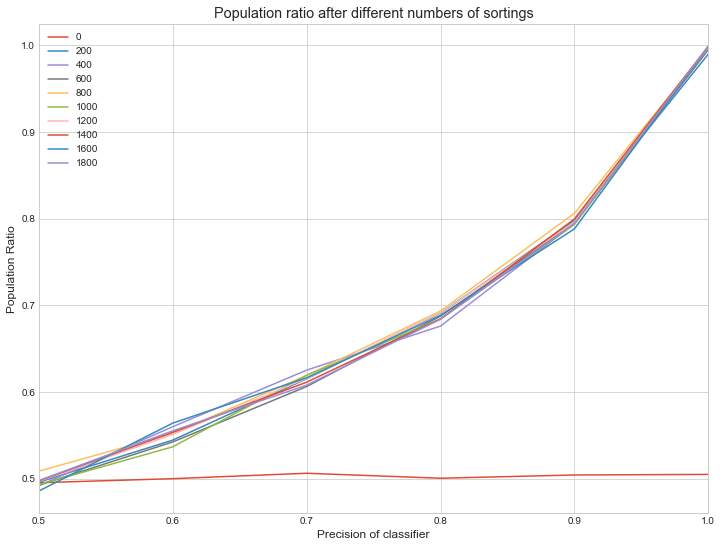

In [39]:
for i in range(0, len(classifiers), 200):
    classifiers.iloc[i].plot()
plt.xlabel("Precision of classifier")
plt.ylabel("Population Ratio")
plt.title("Population ratio after different numbers of sortings")
plt.legend(loc = 'upper left');

## compare constant and normal distribution

In [41]:
distdata = []
for dist in ['Const', 'Norm']:
    print('in dist', dist)
    config1 = config(hi_lim=1, low_lim=0, start_chamber='A1', size=1000, fraction=0.5, max_sortings=1000,
               bunch_size=4, rand_bunch=dist, prec=1, classify_odds=1)
    all_data = simulate(5, conf=config1)
    ps = prep_4plot(all_data).mean(axis=1)
    ps.name = dist
    distdata.append(ps)
distclassifiers = pd.DataFrame(distdata).transpose()

in dist Const
in dist Norm


In [42]:
savepkl('distclassifiers', distclassifiers)

In [43]:
distclassififers = loadpkl('distclassifiers')

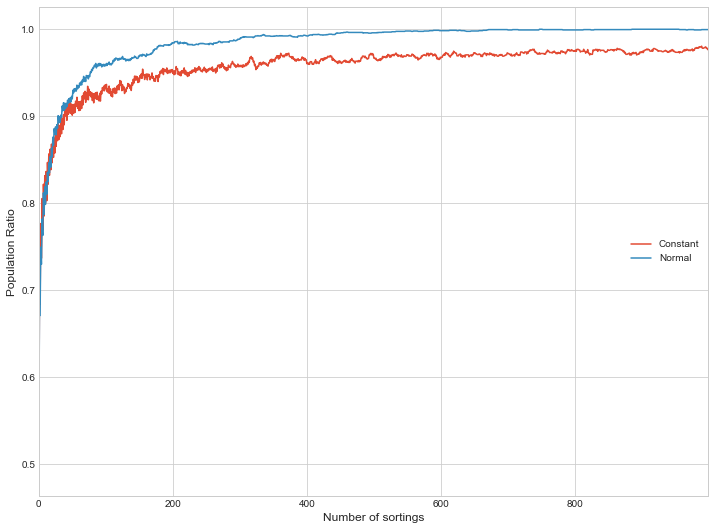

In [44]:
distclassifiers.plot();
plt.xlabel("Number of sortings")
plt.ylabel("Population Ratio")
# plt.title("Population ratio for different distributions")
plt.legend(['Constant', 'Normal'], loc="right")

## run over bunch size

In [46]:
sizedata = []
for size in (2,3,4,6,8,10,15,25,50,100):
    print('in size', size)
    config1 = config(hi_lim=1, low_lim=0, start_chamber='A1', size=1500, fraction=0.5, max_sortings=2000,
               bunch_size=size, rand_bunch="Const", prec=1, classify_odds=1)
    all_data = simulate(5, conf=config1)
    ps = prep_4plot(all_data).mean(axis=1)
    ps.name = str(size)
    sizedata.append(ps)
sizeclassifiers = pd.DataFrame(sizedata).transpose()

in size 2
in size 3
in size 4
in size 6
in size 8
in size 10
in size 15
in size 25
in size 50
in size 100


In [47]:
savepkl('sizeclassifiers', sizeclassifiers)

In [48]:
sizeclassifiers = loadpkl('sizeclassifiers')

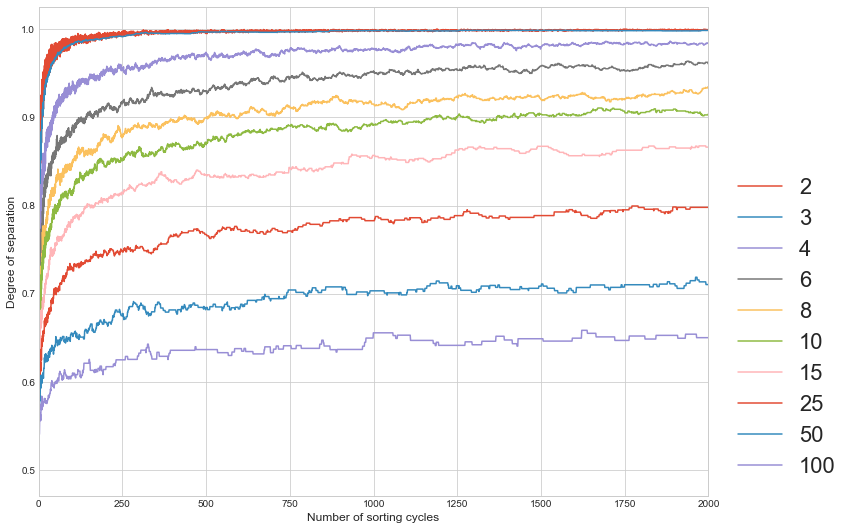

In [49]:
ax = sizeclassifiers.plot();
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (12, 12 / 4 * 3)
plt.xlabel("Number of sorting cycles")
plt.ylabel("Degree of separation")
# plt.title("Degree of separation for different bunch sizes")
# plt.subplots_adjust(right=0.2)
lgd = ax.legend(loc="lower right", bbox_to_anchor=(1.22, 0));

## running over contant bunch size ratios

In [51]:
constratiodata = []
ratio = 0.1
for s in (50,100,250,500):
    print('in size', s)
    config1 = config(hi_lim=1, low_lim=0, start_chamber='A1', size=s, fraction=0.5, max_sortings=2000,
               bunch_size=int(s*ratio), rand_bunch="Const", prec=1, classify_odds=1)
    all_data = simulate(5, conf=config1)
    ps = prep_4plot(all_data).mean(axis=1)
    ps.name = str(s)
    constratiodata.append(ps)
constratioclassifiers = pd.DataFrame(constratiodata).transpose()

in size 50
in size 100
in size 250
in size 500


In [52]:
savepkl('constantratioclassifiers', constratioclassifiers)

In [53]:
constratioclassifiers = loadpkl('constantratioclassifiers')

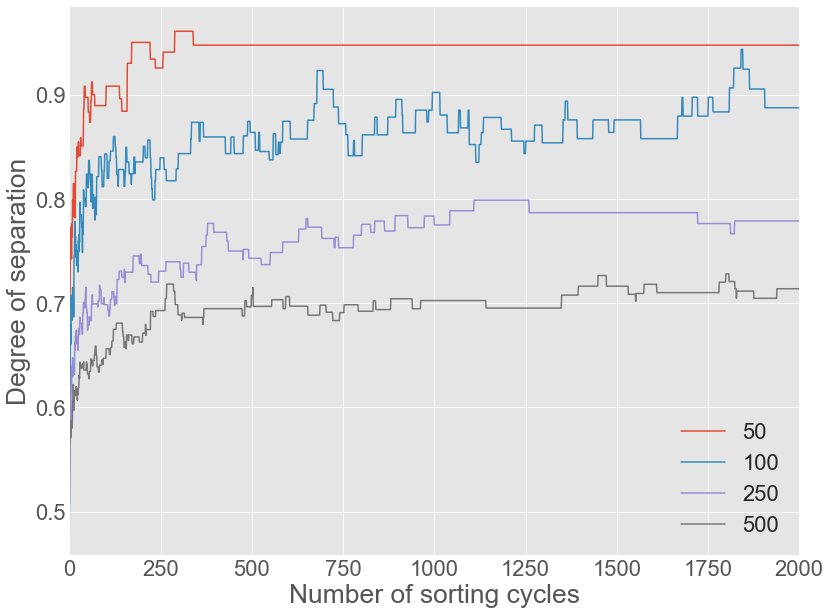

In [54]:
constratioclassifiers.plot();
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (12, 12 / 4 * 3)
plt.xlabel("Number of sorting cycles")
plt.ylabel("Degree of separation")
# plt.title("Degree of separation at constant ratio over size")
plt.legend(loc="lower right");
plt.tight_layout()

## over ratio at const bunch size

In [56]:
constbunchdata = []
for s in (50,100,250,500,1500):
    print('in size', s)
    config1 = config(hi_lim=1, low_lim=0, start_chamber='A1', size=s, fraction=0.5, max_sortings=2000,
               bunch_size=10, rand_bunch="Const", prec=1, classify_odds=1)
    all_data = simulate(5, conf=config1)
    ps = prep_4plot(all_data).mean(axis=1)
    ps.name = str(s)
    constbunchdata.append(ps)
constbunchclassifiers = pd.DataFrame(constbunchdata).transpose()

in size 50
in size 100
in size 250
in size 500
in size 1500


In [57]:
savepkl('constbunchclassifiers', constbunchclassifiers)

In [58]:
constbunchclassifiers = loadpkl('constbunchclassifiers')

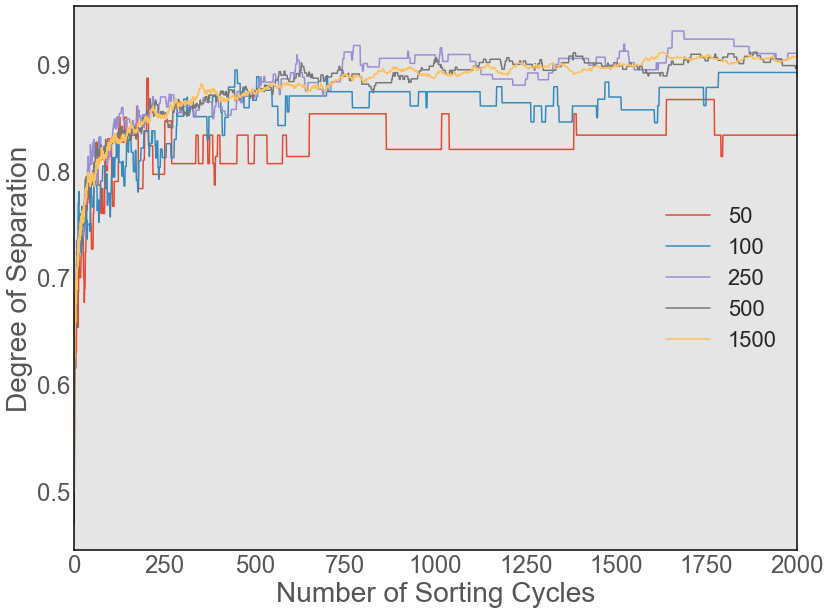

In [59]:
constbunchclassifiers.plot();
plt.style.use('seaborn-whitegrid')
#plt.style.use('ggplot')
ax = plt.axes()
ax.grid(False)
ax.spines['top'].set_color('k')
ax.spines['top'].set_linewidth(1.5)
ax.spines['left'].set_color('k')
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_color('k')
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_color('k')
ax.spines['bottom'].set_linewidth(1.5)
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (12, 12 / 4 * 3)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel("Number of Sorting Cycles", fontsize=28)
plt.ylabel("Degree of Separation", fontsize=28);
# plt.title("Degree of separation over size (w/ bunch size constant)")
plt.legend(loc="right");
plt.tight_layout()

## compare contant and different normal distributions

In [60]:
diffdists = []
config1 = config(hi_lim=1, low_lim=0, start_chamber='A1', size=1500, fraction=0.5, max_sortings=2000,
           bunch_size=10, rand_bunch="Const", prec=1, classify_odds=1)
all_data = simulate(5, conf=config1)
ps = prep_4plot(all_data).mean(axis=1)
ps.name = 'const'
diffdists.append(ps)

In [61]:
config1 = config(hi_lim=1, low_lim=0, start_chamber='A1', size=1500, fraction=0.5, max_sortings=2000,
           bunch_size=10, rand_bunch="Norm", prec=1, classify_odds=1)
all_data = simulate(5, conf=config1)
ps = prep_4plot(all_data).mean(axis=1)
ps.name = 'Norm8'
diffdists.append(ps)

In [62]:
config1 = config(hi_lim=1, low_lim=0, start_chamber='A1', size=1500, fraction=0.5, max_sortings=2000,
           bunch_size=10, rand_bunch="Norm", prec=1, classify_odds=1)
all_data = simulate(5, conf=config1)
ps = prep_4plot(all_data).mean(axis=1)
ps.name = 'Norm4'
diffdists.append(ps)

In [63]:
config1 = config(hi_lim=1, low_lim=0, start_chamber='A1', size=1500, fraction=0.5, max_sortings=2000,
           bunch_size=10, rand_bunch="Norm", prec=1, classify_odds=1)
all_data = simulate(5, conf=config1)
ps = prep_4plot(all_data).mean(axis=1)
ps.name = 'Norm2'
diffdists.append(ps)

In [64]:
savepkl('diffdists', diffdists)

In [65]:
diffdists = loadpkl('diffdists')

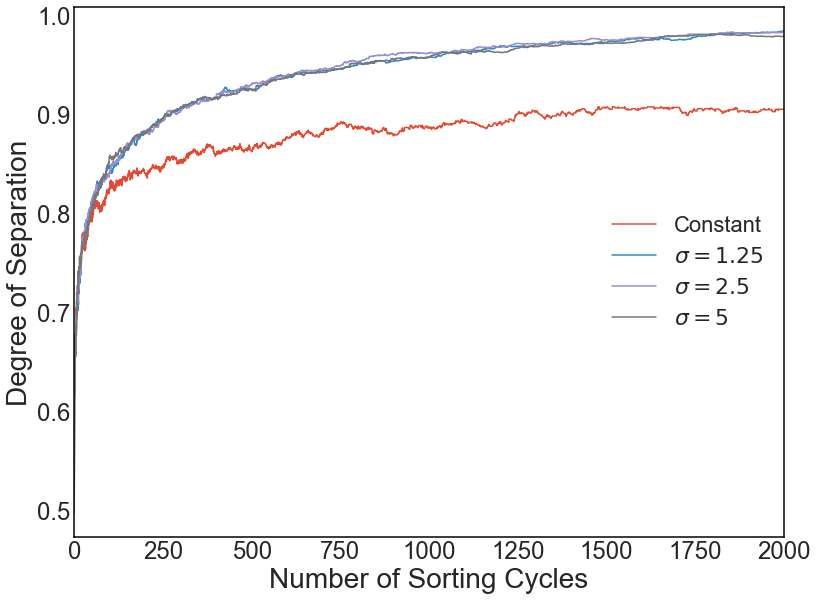

In [66]:
pd.DataFrame(diffdists).transpose().plot();
ax = plt.axes()
ax.grid(False)
ax.spines['top'].set_color('k')
ax.spines['top'].set_linewidth(1.5)
ax.spines['left'].set_color('k')
ax.spines['left'].set_linewidth(1.5)
ax.spines['right'].set_color('k')
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_color('k')
ax.spines['bottom'].set_linewidth(1.5)
plt.rcParams.update({'font.size': 28})
plt.rcParams['figure.figsize'] = (12, 12 / 4 * 3)
plt.xlabel("Number of Sorting Cycles", fontsize=28)
plt.ylabel("Degree of Separation", fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(("Constant", r'$\sigma = 1.25$', r"$\sigma = 2.5$", r"$\sigma = 5$"),loc="right", fontsize=22)
# plt.tick_params(fontsize=22)
plt.tight_layout()
# plt.title("Degree of separation over Normal distributions with different standard deviations", y=1.05, fontsize=22)

## simulate droplet system

In [ ]:
config1 = config(hi_lim=1, low_lim=0, start_chamber='A1', size=300, fraction=0.5, max_sortings=100,
               bunch_size=3, rand_bunch='Droplets', prec=1, classify_odds=1)
droplet_all_data = simulate(5, conf=config1)
droplet_ps = prep_4plot(droplet_all_data)
plot_all(droplet_ps)